In [11]:
import numpy as np
import copy

import ufl
from dolfinx.fem import Function, FunctionSpace
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_unit_square
from dolfinx.nls.petsc import NewtonSolver
from ufl import dx, grad, inner

from mpi4py import MPI
from petsc4py import PETSc

import dolfinx.plot as plot
import matplotlib.pyplot as plt

In [12]:
lmbda = 1.0e-02     # surface parameter
dt = 5.0e-06     # time step
theta = 0.5     # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson

msh = create_unit_square(MPI.COMM_WORLD, 96, 96, CellType.triangle)
P1 = ufl.FiniteElement("Lagrange", msh.ufl_cell(), 1)
ME = FunctionSpace(msh, P1 * P1)


In [13]:
# Trial and test functions of the space `ME` are now defined:

q, v = ufl.TestFunctions(ME)

u = Function(ME)     # current solution
u0 = Function(ME)     # solution from previous converged step

# Split mixed functions
c, mu = ufl.split(u)
c0, mu0 = ufl.split(u0)


In [14]:
# Zero u
u.x.array[:] = 0.0

# Interpolate initial condition
u.sub(0).interpolate(lambda x: 0.63 + 0.02 * (0.5 - np.random.rand(x.shape[1])))
u.x.scatter_forward()

In [15]:
# Compute the chemical potential df/dc
c = ufl.variable(c)
f = 100 * c**2 * (1 - c)**2
dfdc = ufl.diff(f, c)

In [16]:
# mu_(n+theta)
mu_mid = (1.0-theta) * mu0 + theta*mu

# which is then used in the definition of the variational forms:

# Weak statement of the equations
F0 = inner(c, q) * dx - inner(c0, q) * dx + dt * inner(grad(mu_mid), grad(q)) * dx
F1 = inner(mu, v) * dx - inner(dfdc, v) * dx - lmbda * inner(grad(c), grad(v)) * dx
F = F0 + F1

In [17]:
# Create nonlinear problem and Newton solver
problem = NonlinearProblem(F, u)
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6

# We can customize the linear solver used inside the NewtonSolver by
# modifying the PETSc options
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [18]:
# Output file
file = XDMFFile(MPI.COMM_WORLD, "demo_ch/output.xdmf", "w")
file.write_mesh(msh)

# Step in time
t = 0.0

#  Reduce run time if on test (CI) server
T = 10 * dt
V0, dofs = ME.sub(0).collapse()

# Prepare viewer for plotting the solution during the computation
c = u.sub(0)
u0.x.array[:] = u.x.array
while (t < T):
    t += dt
    r = solver.solve(u)
    print(f"Time {t:.0G}: num iterations: {r[0]}")
    u0.x.array[:] = u.x.array
    file.write_function(c, t)
    if int(t / dt) == 5: check_c1 = copy.deepcopy(u.x.array);print('Checked')

file.close()

Time 5E-06: num iterations: 3
Time 1E-05: num iterations: 3
Time 2E-05: num iterations: 4
Time 2E-05: num iterations: 4
Time 3E-05: num iterations: 4
Checked
Time 3E-05: num iterations: 5
Time 4E-05: num iterations: 6
Time 4E-05: num iterations: 6
Time 5E-05: num iterations: 5
Time 5E-05: num iterations: 5


In [19]:
len(check_c1)

18818

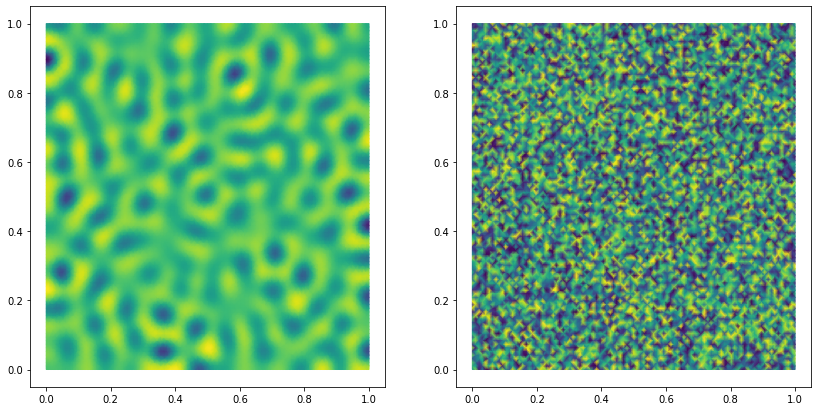

In [21]:
u.sub(0).interpolate(lambda x: 0.63 + 0.02 * (0.5 - np.random.rand(x.shape[1])))
check_c2 = u.sub(0).x.array

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

check_c = check_c1
c_topology, c_cell_types, c_geometry = plot.create_vtk_mesh(V0)
check_c = np.vstack((np.arange(len(check_c)), check_c)).T[dofs][:, 1]
c_data = np.column_stack((c_geometry[:, 0:2], check_c))
x_data = c_data[:, 0]
y_data = c_data[:, 1]
z_data = c_data[:, 2]
ax[0].tripcolor(x_data, y_data, z_data, shading='gouraud')

check_c = check_c2
c_topology, c_cell_types, c_geometry = plot.create_vtk_mesh(V0)
check_c = np.vstack((np.arange(len(check_c)), check_c)).T[dofs][:, 1]
c_data = np.column_stack((c_geometry[:, 0:2], check_c))
x_data = c_data[:, 0]
y_data = c_data[:, 1]
z_data = c_data[:, 2]
ax[1].tripcolor(x_data, y_data, z_data, shading='gouraud')
